In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [4]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
interval = '1m'
pair = 'BTCUSDT'

In [5]:
from trade_utils import initialize_ohlc_df

try:
    df = pd.read_csv('data/' + pair + '-' + interval + '-binance.csv')
    df['OpenTime'] = pd.to_datetime(df['OpenTime'])
    df.set_index('OpenTime', inplace=True)
except FileNotFoundError:
    df = initialize_ohlc_df()


In [6]:
df.shape

(803832, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803832 entries, 2020-01-01 00:00:00 to 2021-07-13 14:22:00
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   OpenPrice   803832 non-null  float64
 1   HighPrice   803832 non-null  float64
 2   LowPrice    803832 non-null  float64
 3   ClosePrice  803832 non-null  float64
 4   Volume      803832 non-null  float64
dtypes: float64(5)
memory usage: 36.8 MB


In [8]:
df.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2020-01-01 00:00:00,7195.24,7196.25,7183.14,7186.68,51.642812
2020-01-01 00:01:00,7187.67,7188.06,7182.20,7184.03,7.248148
2020-01-01 00:02:00,7184.41,7184.71,7180.26,7182.43,11.681677
2020-01-01 00:03:00,7183.83,7188.94,7182.49,7185.94,10.025391
2020-01-01 00:04:00,7185.54,7185.54,7178.64,7179.78,14.911105


In [9]:
df.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-07-13 14:18:00,32515.15,32538.97,32514.79,32526.96,14.180629
2021-07-13 14:19:00,32526.98,32540.14,32513.27,32513.27,23.642327
2021-07-13 14:20:00,32513.26,32519.17,32475.83,32483.12,41.768148
2021-07-13 14:21:00,32484.48,32523.36,32483.00,32520.59,56.241263
2021-07-13 14:22:00,32520.58,32527.83,32501.28,32512.51,17.511692


In [10]:
from binance_utils import update_historical_data

df = update_historical_data(df, pair, interval)

In [11]:
# only data from 2020 until now are going to save
df = df['2020-1-1':]

filename = 'data/' + pair + '-' + interval + '-binance.csv'
df.to_csv(filename)

In [12]:
summaries = {'OpenPrice': 'first', 'HighPrice': 'max', 'LowPrice': 'min', 'ClosePrice': 'last', 'Volume': 'sum'}

df_1m = df.copy()

df_15m = df.resample('15min').agg(summaries)
df_15m.dropna(inplace=True)

df_1h = df.resample('1H').agg(summaries)
df_1h.dropna(inplace=True)

df_4h = df.resample('4H').agg(summaries)
df_4h.dropna(inplace=True)

df_1d = df.resample('1D').agg(summaries)
df_1d.dropna(inplace=True)

In [13]:
# select data to generate indicators
data = df_1h.copy()
#data = df_1d.copy()

In [14]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2020-12-27 16:00:00,27360.09,27490.00,26600.00,27089.44,9368.278618
2021-05-03 13:00:00,58558.26,58645.09,57260.00,57697.33,3671.857607
2020-09-17 01:00:00,10993.67,11034.00,10950.04,10958.42,2303.616641
2020-07-01 06:00:00,9142.61,9148.76,9125.31,9134.74,1043.111087
2021-02-13 18:00:00,46855.23,47022.26,46738.24,46792.05,1858.546082
2021-04-26 04:00:00,52398.99,52722.35,52000.00,52299.99,3111.162454
2020-11-02 11:00:00,13492.70,13513.16,13357.42,13402.18,6135.923579
2020-04-19 14:00:00,7103.46,7113.24,7055.60,7106.99,4630.373422
2020-04-27 20:00:00,7698.74,7709.07,7680.32,7694.30,1073.828036


In [15]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate daily returns
data['daily_return'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous day

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['signal'], data['MACDH'] = macd(data.ClosePrice)

# RSI
data['rsi'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [16]:
#filename = 'data/' + pair + '1h-indicators-binance.csv'
#data.to_csv(filename)

In [17]:
#limit data to plot
data = data['2021-6-1':]

In [18]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

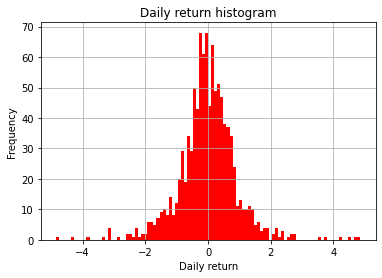

In [19]:
# Plot the histogram
data['daily_return'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

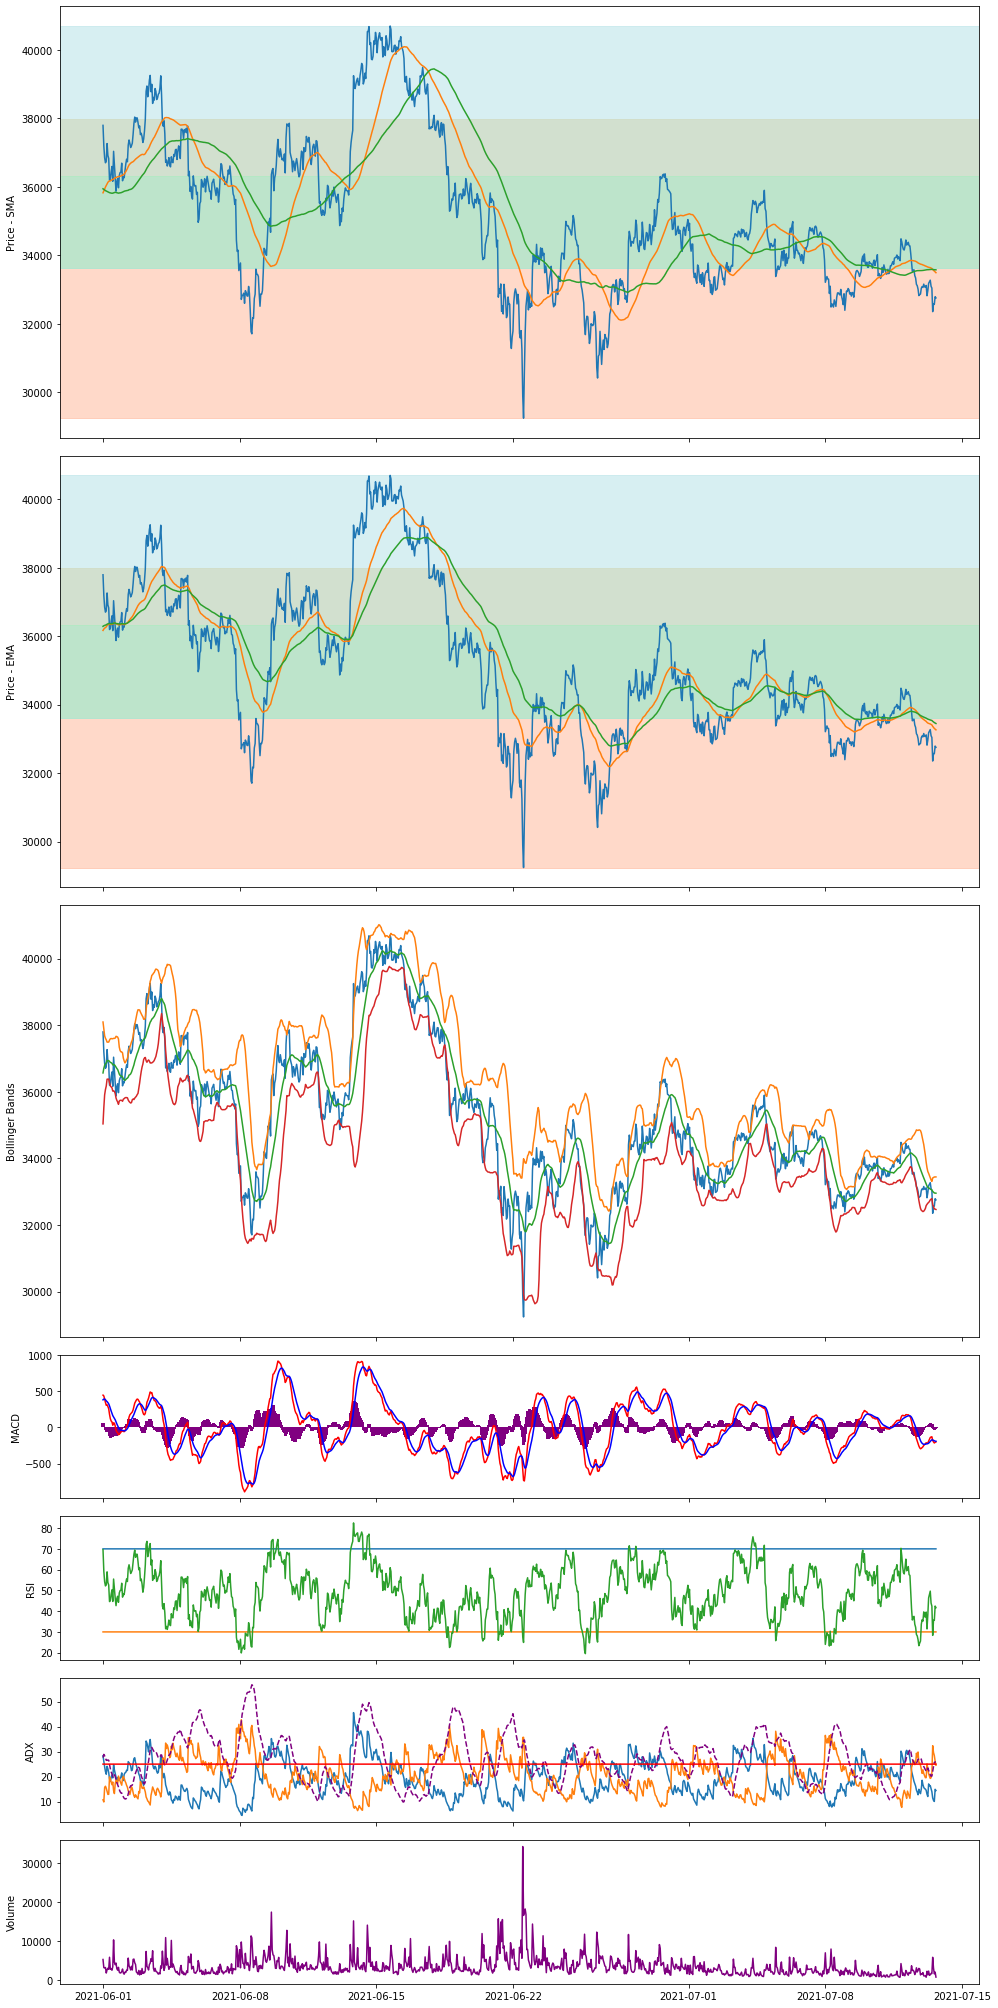

In [20]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.plot(data.index, data['signal'], label='Signal Line', color='blue')
ax4.bar(data.index, data['MACDH'], color="purple", width = timedelta(hours=4))
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['rsi'], label='rsi')
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
ax7.plot(data.index, data['Volume'], color='purple')
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [21]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

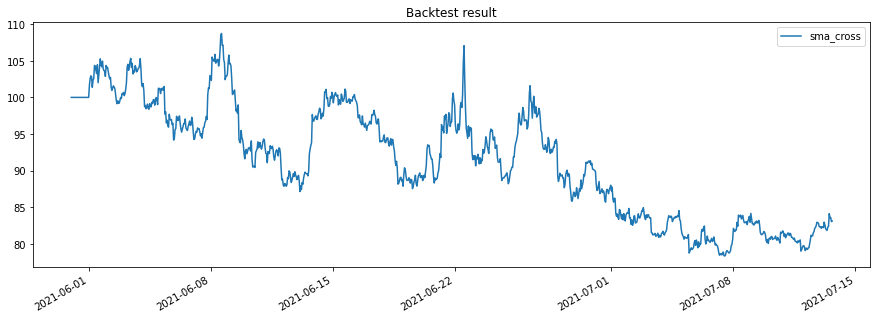

In [22]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_backtest = signal_strategy(price_data.copy(), signal, 'sma_cross')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

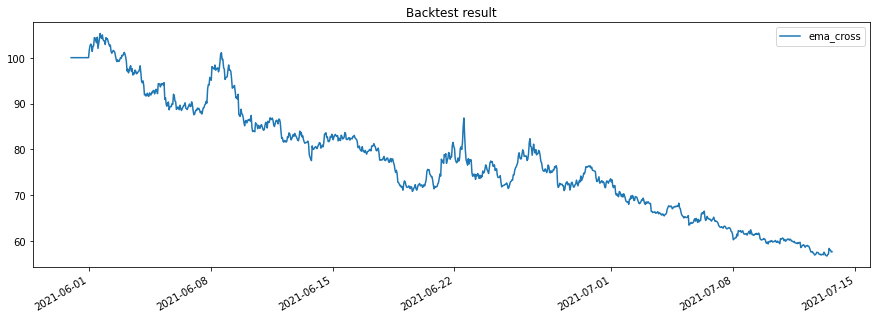

In [23]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_backtest = signal_strategy(price_data.copy(), signal, 'ema_cross')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

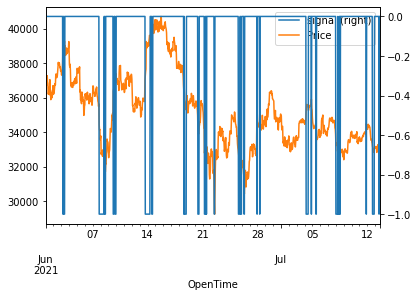

In [24]:
from backtest_utils import get_rsi_signal, signal_strategy

signal = get_rsi_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

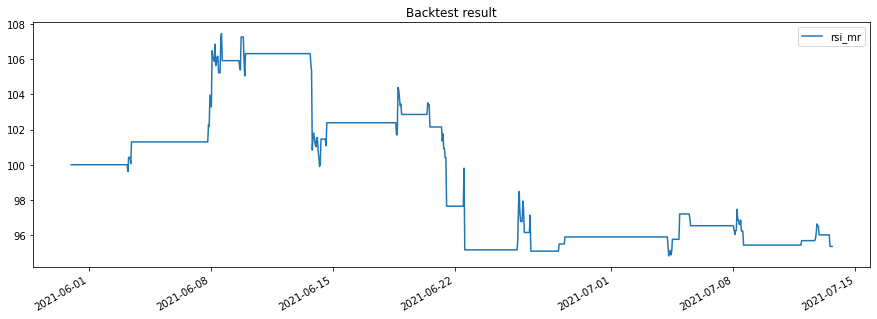

In [25]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

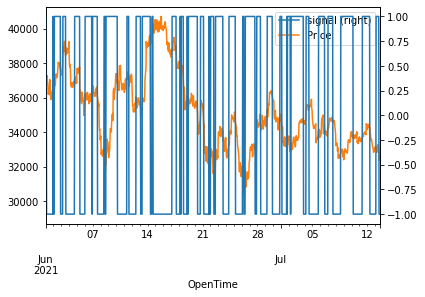

In [26]:
from backtest_utils import get_macd_signal, signal_strategy

signal = get_macd_signal(data[['signal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

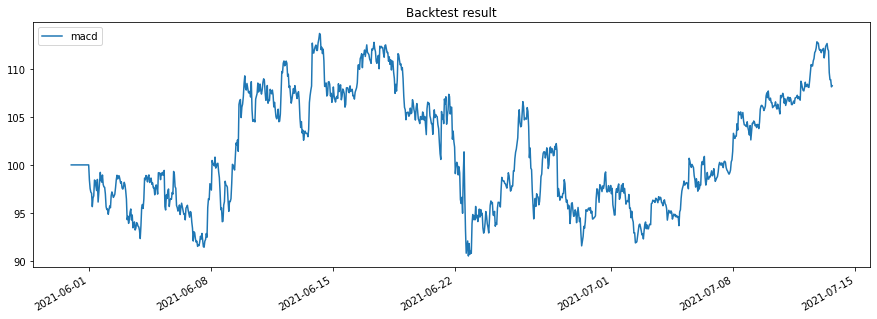

In [27]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [28]:
print(bt_result.display())
print(bt_result.get_transactions())

Stat                 macd
-------------------  ----------
Start                2021-05-31
End                  2021-07-13
Risk-free rate       0.00%

Total Return         8.27%
Daily Sharpe         1.03
Daily Sortino        1.80
CAGR                 96.31%
Max Drawdown         -19.33%
Calmar Ratio         4.98

MTD                  10.64%
3m                   -
6m                   -
YTD                  8.27%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  96.31%

Daily Sharpe         1.03
Daily Sortino        1.80
Daily Mean (ann.)    68.13%
Daily Vol (ann.)     66.45%
Daily Skew           0.03
Daily Kurt           1.26
Best Day             11.90%
Worst Day            -11.38%

Monthly Sharpe       1.63
Monthly Sortino      9.68
Monthly Mean (ann.)  50.96%
Monthly Vol (ann.)   31.33%
Monthly Skew         -
Monthly Kurt         -
Best Month           10.64%
Worst Month          -2.15%

Yearly Sharpe        -
Yearly Sortin

In [29]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


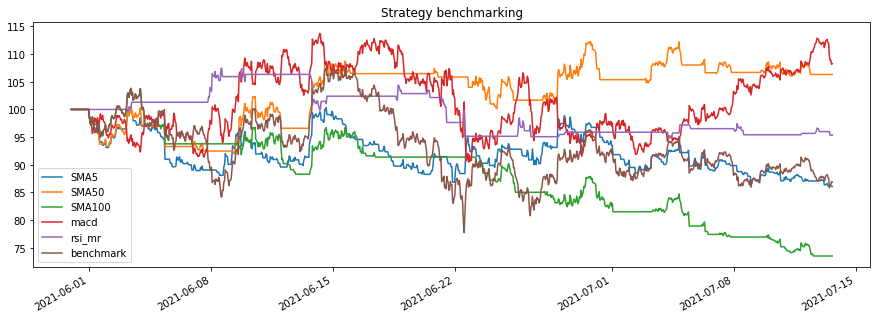

In [30]:
# Run all backtests and plot the resutls
#bt_results = bt.run(macd_bt, sma5, sma30, sma50, benchmark)
bt_results = bt.run(bt_sma5, bt_sma50, bt_sma100, bt_macd, bt_rsi, bt_benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [31]:
bt_result = bt.run(bt_macd)
print(bt_result.display())
print(bt_result.get_transactions())

Stat                 macd
-------------------  ----------
Start                2021-05-31
End                  2021-07-13
Risk-free rate       0.00%

Total Return         8.27%
Daily Sharpe         1.03
Daily Sortino        1.80
CAGR                 96.31%
Max Drawdown         -19.33%
Calmar Ratio         4.98

MTD                  10.64%
3m                   -
6m                   -
YTD                  8.27%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  96.31%

Daily Sharpe         1.03
Daily Sortino        1.80
Daily Mean (ann.)    68.13%
Daily Vol (ann.)     66.45%
Daily Skew           0.03
Daily Kurt           1.26
Best Day             11.90%
Worst Day            -11.38%

Monthly Sharpe       1.63
Monthly Sortino      9.68
Monthly Mean (ann.)  50.96%
Monthly Vol (ann.)   31.33%
Monthly Skew         -
Monthly Kurt         -
Best Month           10.64%
Worst Month          -2.15%

Yearly Sharpe        -
Yearly Sortin

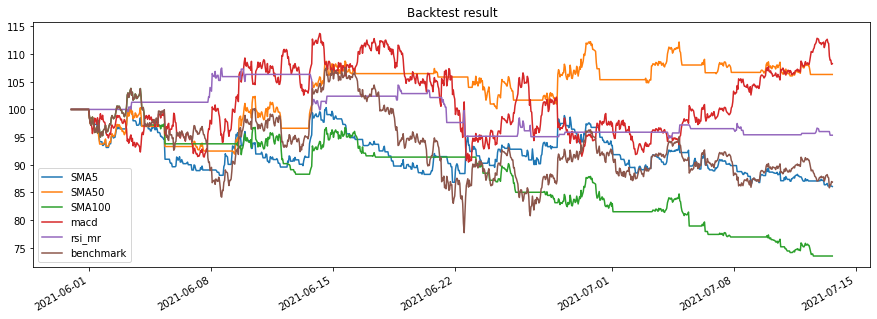

          SMA5   SMA50   SMA100    macd   rsi_mr benchmark
mtd     -8.74%   0.90%  -11.66%  10.64%   -0.56%    -6.42%
3m        nan%    nan%     nan%    nan%     nan%      nan%
6m        nan%    nan%     nan%    nan%     nan%      nan%
ytd    -13.92%   6.32%  -26.47%   8.27%   -4.65%   -13.12%
1y        nan%    nan%     nan%    nan%     nan%      nan%
3y        nan%    nan%     nan%    nan%     nan%      nan%
5y        nan%    nan%     nan%    nan%     nan%      nan%
10y       nan%    nan%     nan%    nan%     nan%      nan%
incep  -72.01%  68.23%  -92.66%  96.31%  -33.28%   -69.70%


In [32]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)

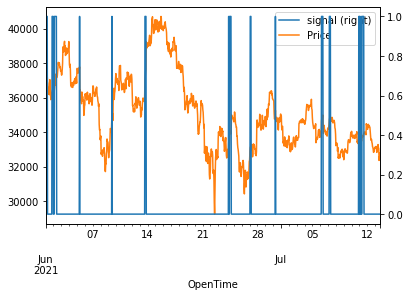

In [33]:
from backtest_utils import get_sma_macd_signal, signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

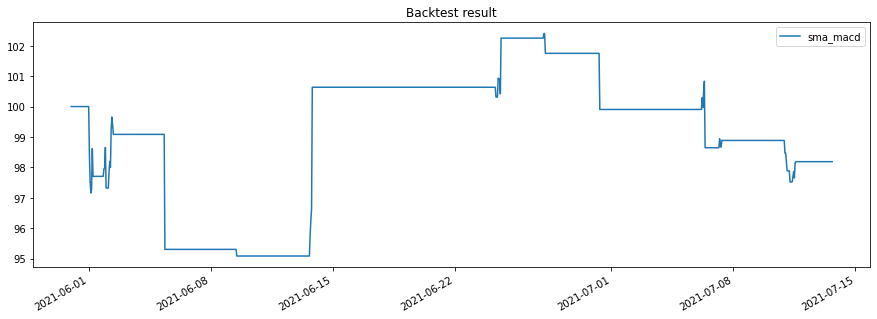

In [34]:
bt_backtest = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

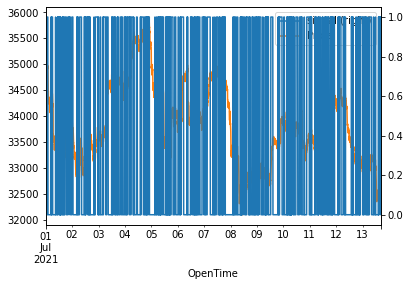

In [35]:
from backtest_utils import get_5_minute_signal, signal_strategy
import bt

summaries = {'OpenPrice': 'first', 'HighPrice': 'max', 'LowPrice': 'min', 'ClosePrice': 'last', 'Volume': 'sum'}
df_5m = df.resample('5min').agg(summaries)
df_5m.dropna(inplace=True)

df_5m['EMA20'] = ema(df_5m['ClosePrice'], 20)
df_5m['MACD'], df_5m['signal'], df_5m['MACDH'] = macd(df_5m.ClosePrice)

df_5m = df_5m['2021-7-1':]

signal = get_5_minute_signal(df_5m[['ClosePrice']].copy(), df_5m[['MACDH']].copy(), df_5m[['EMA20']].copy())

# Merge the data
combined_df = bt.merge(signal, df_5m[['ClosePrice']])
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

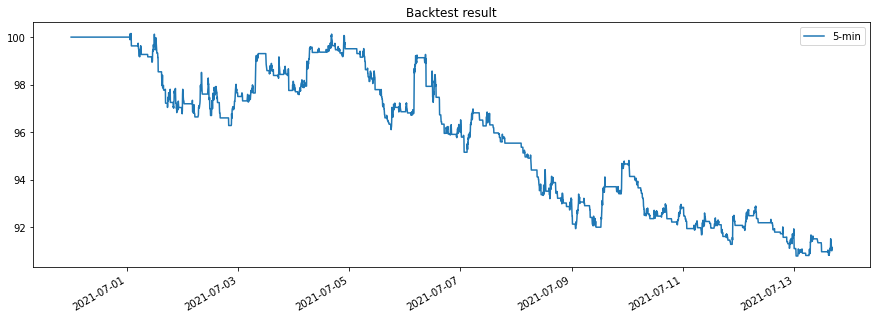

In [36]:
bt_backtest = signal_strategy(df_5m[['ClosePrice']].copy(), signal, '5-min')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

## Real-time trade

In [ ]:
from binance.client import Client

from datetime import datetime
import time, json

In [ ]:
from binance_utils import get_twm
from binance import ThreadedWebsocketManager

from datetime import datetime
import time, json

df_real_time = pd.DataFrame(columns=[
        'OpenTime',
        'OpenPrice', 
        'HighPrice', 
        'LowPrice', 
        'ClosePrice', 
        'Volume'])

symbol = 'BTCUSDT'

twm = get_twm()
twm.start()

def handle_socket_message(msg):
    #print(f"message type: {msg['e']}")
    #print(msg)

    global df_real_time

    candle = msg['k']
    timestamp = candle['t'] / 1000
    timestamp = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

    is_candle_closed = candle['x']

    # Print this amount
    print("{} - Open: {} High: {} Low: {} Close: {} Volume: {}".format(
        timestamp, 
        candle['o'], 
        candle['h'], 
        candle['l'], 
        candle['c'],
        candle['v']))
    
    if is_candle_closed:
        print('candle closed')

        new_row = {
            'OpenTime':timestamp, 
            'OpenPrice':candle['o'], 
            'HighPrice':candle['h'], 
            'LowPrice':candle['l'], 
            'ClosePrice':candle['c'], 
            'Volume':candle['v']}

        #append row to the dataframe
        df_real_time = df_real_time.append(new_row, ignore_index=True)

twm.start_kline_socket(callback=handle_socket_message, symbol=symbol, interval='1m')

# let some data flow..
time.sleep(160)

twm.stop()

df_real_time.head()

## Tests

In [ ]:
from binance_utils import init
from binance.client import Client

client = init()
candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1HOUR)

In [ ]:
# Tests
print(df.index.day[-2])
print(df.index.day[-1])
df.index.day[-2] != df.index.day[-1]